In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

In [27]:
# 1. Definir la arquitectura del modelo (debe coincidir con la entrenada)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 3) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
# 2. Cargar el modelo preentrenado
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('modelo/torch_brain_cancer_91', map_location=device, weights_only=True))  # Ajusta la ruta
model.eval()
print("Modelo cargado correctamente")

# 3. Configurar transformaciones para validación
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Modelo cargado correctamente


In [29]:
# 4. Cargar el dataset de validación
val_dir = 'data/val'  # Ajusta la ruta a tu carpeta val
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Obtener nombres de las clases
classes = val_dataset.classes
print(f"Clases: {classes}")

# 5. Evaluar el modelo en el conjunto de validación
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Precisión en el conjunto de validación: {accuracy:.2f}%')

Clases: ['brain_glioma', 'brain_menin', 'brain_tumor']
Precisión en el conjunto de validación: 90.63%


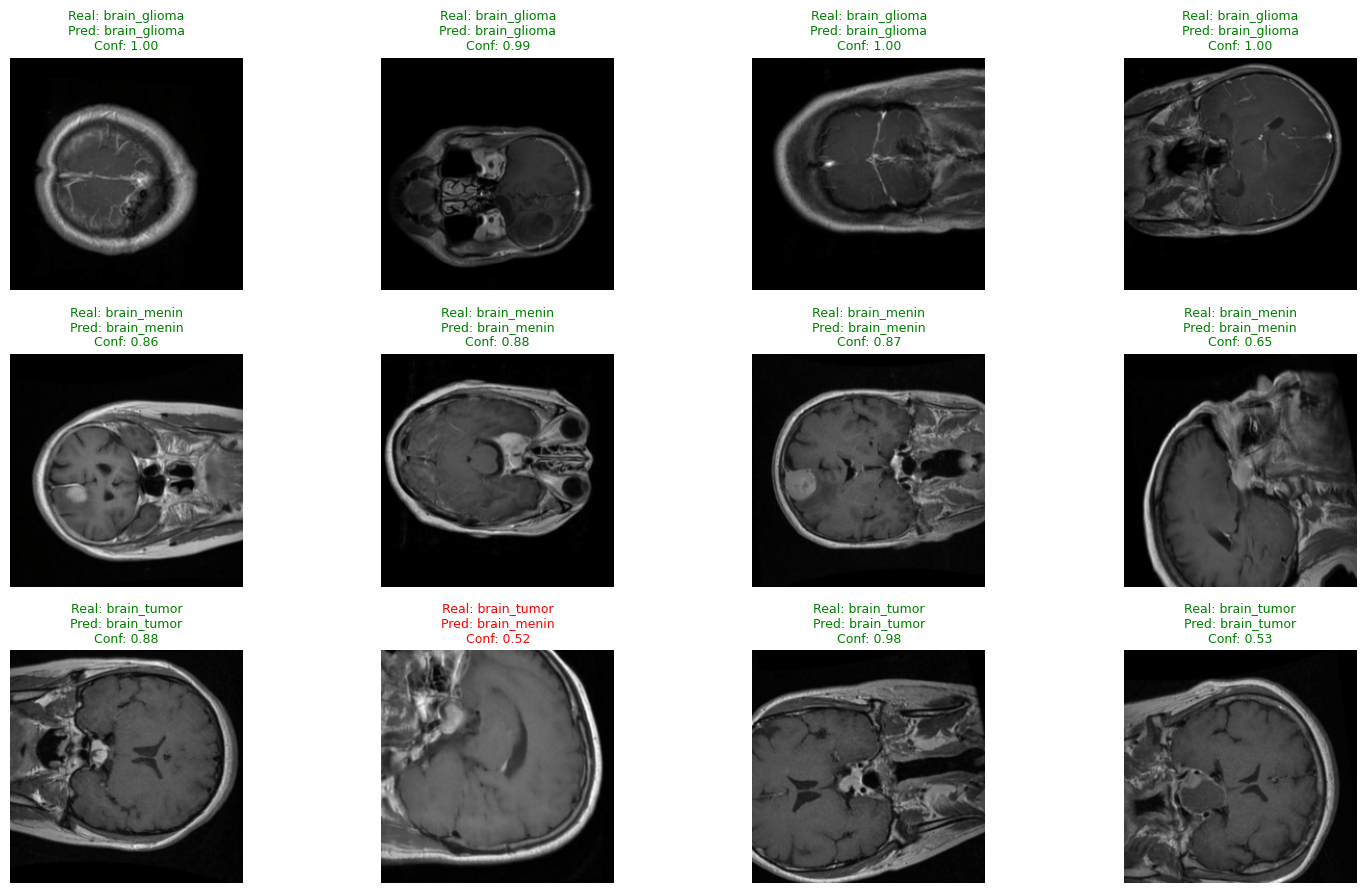


Distribución de probabilidades para la primera imagen:
brain_glioma: 0.9999
brain_menin: 0.0001
brain_tumor: 0.0000


In [30]:
# 6. Visualizar predicciones con muestras balanceadas de todas las clases
def imshow(img, title=None):
    """Función para mostrar imágenes"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title, fontsize=9)
    plt.axis('off')

# Obtener índices de ejemplos para cada clase
class_indices = {}
for i, class_name in enumerate(classes):
    # Encontrar todos los índices que pertenecen a esta clase
    indices = [idx for idx, (_, label) in enumerate(val_dataset) if label == i]
    class_indices[class_name] = indices

# Seleccionar aleatoriamente 4 imágenes de cada clase
num_samples_per_class = 4
selected_indices = []
for class_name, indices in class_indices.items():
    if len(indices) >= num_samples_per_class:
        selected_indices.extend(np.random.choice(indices, num_samples_per_class, replace=False))
    else:
        selected_indices.extend(indices)  # Si hay menos muestras, tomar todas

# Crear un DataLoader con las imágenes seleccionadas
from torch.utils.data import Subset
subset = Subset(val_dataset, selected_indices)
subset_loader = DataLoader(subset, batch_size=len(selected_indices), shuffle=False)

# Obtener las imágenes y etiquetas
images, labels = next(iter(subset_loader))
images, labels = images.to(device), labels.to(device)

# Realizar predicciones
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    probabilities = F.softmax(outputs, dim=1)

# Mover a CPU para visualización
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Mostrar imágenes con predicciones
fig = plt.figure(figsize=(15, 12))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 4, idx+1)
    
    # Obtener probabilidades para todas las clases
    prob_values = probabilities[idx].cpu().numpy()
    prob_text = "\n".join([f"{classes[i]}: {prob_values[i]:.2f}" for i in range(len(classes))])
    
    # Determinar color del texto (verde si es correcto, rojo si es incorrecto)
    color = "green" if labels[idx] == preds[idx] else "red"
    
    imshow(images[idx], 
           f'Real: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}\nConf: {probabilities[idx][preds[idx]].item():.2f}')
    
    # Cambiar color del título según si la predicción es correcta o no
    ax.title.set_color(color)

plt.tight_layout()
plt.show()

# Mostrar también la distribución de probabilidades para la primera imagen como ejemplo
print("\nDistribución de probabilidades para la primera imagen:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {probabilities[0][i].item():.4f}")

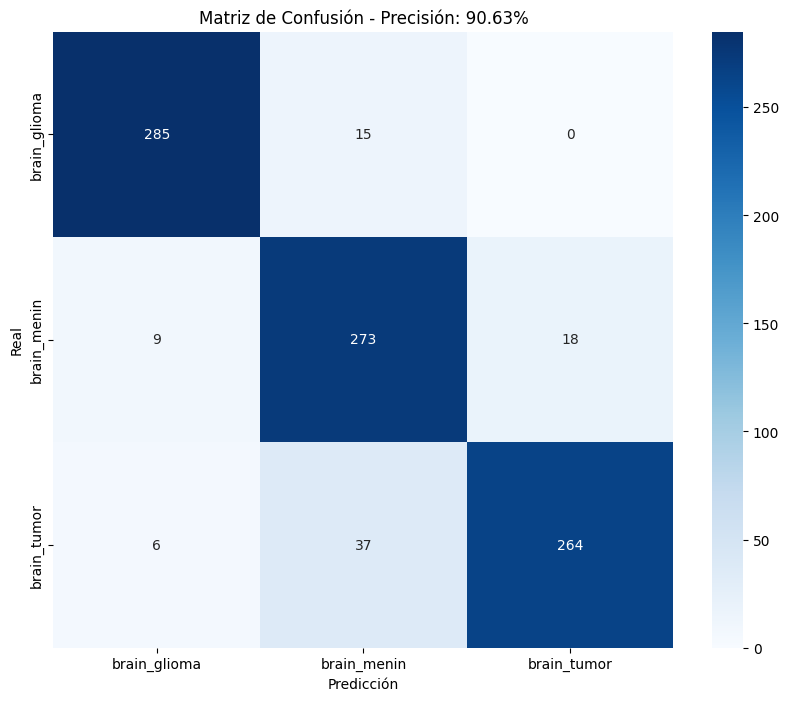

In [31]:
# 7. Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión - Precisión: {accuracy:.2f}%')
plt.show()

In [35]:
print(cm)

[[285  15   0]
 [  9 273  18]
 [  6  37 264]]


In [32]:
# 8. Reporte de clasificación detallado
print("\nReporte de Clasificación:")
print(classification_report(all_labels, all_preds, target_names=classes))

# 9. Calcular precisión por clase
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nPrecisión por clase:")
for i in range(len(classes)):
    print(f'{classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')


Reporte de Clasificación:
              precision    recall  f1-score   support

brain_glioma       0.95      0.95      0.95       300
 brain_menin       0.84      0.91      0.87       300
 brain_tumor       0.94      0.86      0.90       307

    accuracy                           0.91       907
   macro avg       0.91      0.91      0.91       907
weighted avg       0.91      0.91      0.91       907


Precisión por clase:
brain_glioma: 95.00%
brain_menin: 91.00%
brain_tumor: 85.99%
